In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

RANDOM_STATE = 42

dataset = pd.read_csv("S06-hw-dataset-02.csv")
print(dataset.head())


def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

   id       f01       f02       f03        f04       f05       f06       f07  \
0   1 -0.149235 -2.826966 -0.522901  -4.198449  1.364943  0.815043 -1.195518   
1   2 -1.966180 -4.877542  0.268367  -9.607791  0.097149  1.347185 -3.872575   
2   3 -0.555964 -0.999920  0.209673 -14.119498 -1.808950 -0.006222 -4.651108   
3   4 -2.049199 -5.600713 -1.664677  -6.263893 -5.224455  0.848351  1.407210   
4   5 -0.220556  4.889479 -2.235840   6.450046  0.774389 -2.382625  2.584816   

        f08       f09  ...       f29       f30       f31       f32       f33  \
0 -1.932232  2.396353  ... -0.159323  0.448015  0.572745  0.149916  0.878392   
1 -0.395117  1.710068  ... -0.389212  1.383794  0.169876  0.043969 -0.963545   
2  0.911944 -0.289037  ... -1.383970  3.044321 -0.182864  1.425649 -8.418598   
3 -0.542080  0.119102  ... -2.713080  2.762637 -0.520796 -0.142455  1.668338   
4  4.211856 -0.317889  ... -1.302872  2.478862  1.528610  1.098131  3.547087   

        f34        f35    x_int_1    x

In [3]:
print(dataset.describe())

                 id           f01           f02           f03           f04  \
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000   
mean    9000.500000     -0.418555      0.614251      0.004559      0.059000   
std     5196.296758      2.178005      3.926778      1.000134      5.713672   
min        1.000000    -10.014698    -15.510323     -4.031762    -23.663256   
25%     4500.750000     -1.866134     -2.048192     -0.673127     -3.544964   
50%     9000.500000     -0.465100      0.600291      0.003581      0.072826   
75%    13500.250000      0.966393      3.229850      0.671390      3.689490   
max    18000.000000      9.589975     15.417329      3.817025     26.815691   

                f05           f06           f07           f08           f09  \
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000   
mean       0.405086      0.012123     -0.283473     -0.266880      0.255107   
std        2.497581      0.987226      2.193891    

In [4]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [5]:
print(dataset["target"].value_counts(normalize=True))

target
0    0.737389
1    0.262611
Name: proportion, dtype: float64


In [6]:
X = dataset.iloc[:, 1:-1]
y = dataset["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=RANDOM_STATE, stratify=y)

results = []
best_models = {}  # label -> fitted best estimator
search_summaries = {}  # label -> краткая инфа о подборе


Фиксированный seed важен для воспроизводимости результатов, а stratify для такого же распределения таргета в train и test выборках, как и в полном датасете.

In [7]:
dummyClassifier = DummyClassifier(strategy='most_frequent')
dummyClassifier.fit(X_train, y_train)

results.append(evaluate_on_test(dummyClassifier, X_test, y_test, "Dummy(most_frequent)"))
best_models["Dummy(most_frequent)"] = dummyClassifier

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=1.0, random_state=RANDOM_STATE))
])

param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
}

lr_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

lr_search.fit(X_train, y_train)
best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)"))
print(search_summaries["LogReg(scaled)"])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'best_params': {'logreg__C': 1000.0}, 'best_cv_roc_auc': 0.8034448981095345}


У dummy classifier accuracy = 0.73, а у baseline logistic regression - 0.81.

In [9]:
def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search



tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

tree_grid = {
    "max_depth": [None, 3, 5, 8],
    "min_samples_leaf": [1, 5, 10, 20],
}

tree_search = run_search("DecisionTree", tree, tree_grid)
print(search_summaries["DecisionTree"])

{'best_params': {'max_depth': None, 'min_samples_leaf': 20}, 'best_cv_roc_auc': 0.832679546323889}


In [10]:
forest = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)

forest_grid = {
    "max_depth": [None, 3, 5, 8]
}

forest_search = run_search("RandomForest", forest, forest_grid)
print(search_summaries["RandomForest"])

{'best_params': {'max_depth': None}, 'best_cv_roc_auc': 0.928745215551066}


In [11]:
stump = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE)

boost = AdaBoostClassifier(
    estimator=stump,
    random_state=RANDOM_STATE
)

boost_grid = {
    "learning_rate": [0.3, 0.6, 0.9],
    "n_estimators": [50, 100, 400]
}

boost_search = run_search("AdaBoost", boost, boost_grid)
print(search_summaries["AdaBoost"])

{'best_params': {'learning_rate': 0.9, 'n_estimators': 400}, 'best_cv_roc_auc': 0.8330001493088846}


In [12]:
results_df = pd.DataFrame(results)
results_sorted = results_df.copy()
results_sorted["roc_auc_sort"] = results_sorted["roc_auc"].fillna(-1.0)
results_sorted = results_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])
print(results_sorted)

   accuracy        f1   roc_auc                 model
3  0.892222  0.760198  0.928733          RandomForest
2  0.826389  0.654887  0.832561          DecisionTree
4  0.829167  0.606526  0.832221              AdaBoost
1  0.811944  0.560675  0.797694        LogReg(scaled)
0  0.737500  0.000000  0.500000  Dummy(most_frequent)


In [22]:
import json
from pathlib import Path

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)


search_path = Path("artifacts/search_summaries.json")
save_json(search_summaries, search_path)

metrics_path = Path("artifacts/metrics_test.json")
metics_dict = {}
for res in results_sorted.to_dict(orient="records"):
    metics_dict.update({res['model']: {
        'accuracy': res['accuracy'],
        'f1': res['f1'],
        'roc_auc': res['roc_auc']}})
save_json(metics_dict, metrics_path)


print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts/metrics_test.json
Saved: artifacts/search_summaries.json


In [14]:
# Выбор лучшей модели
best_row = results_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

print(best_row.to_dict())

{'accuracy': 0.8922222222222222, 'f1': 0.7601977750309024, 'roc_auc': 0.9287328490718322, 'model': 'RandomForest'}


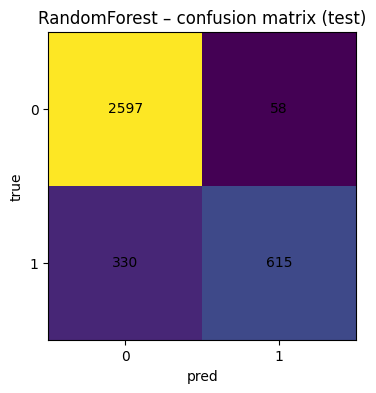

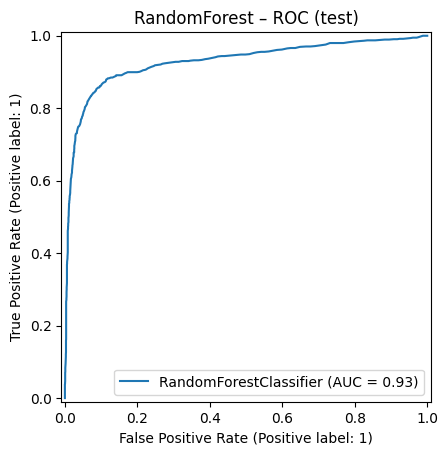

In [15]:
def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.savefig("artifacts/figures/confusion.png")
    plt.show()

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.savefig("artifacts/figures/roc.png")
    plt.show()

y_pred = best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)")
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)")

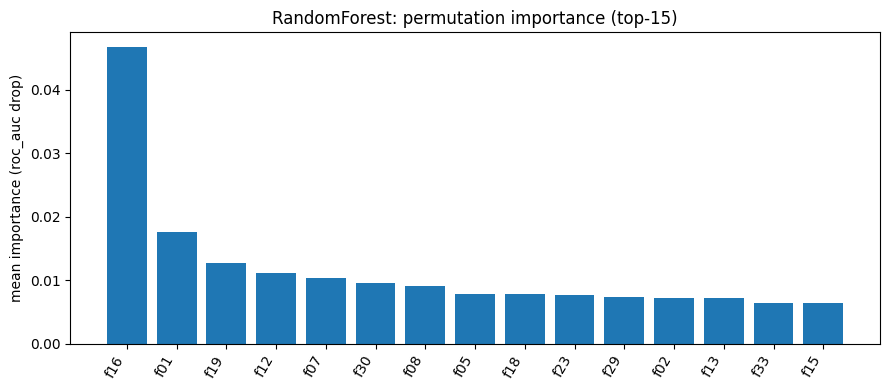

In [16]:
from sklearn.inspection import permutation_importance

feature_names = list(X.keys())
scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.savefig("artifacts/figures/importance.png")
plt.show()

По графику видно, что наибольшую важность имеет признак f16, затем гораздо меньшую важность имеет признак f01. Все остальные признаки имеют важность гораздо меньше, чем f16.

In [17]:
# Сохранение лучшей модели и метаданных
import joblib

model_path = "artifacts/best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, Path("artifacts/best_model_meta.json"))

print("Saved:", model_path)
print("Saved: best_model_meta.json")

Saved: artifacts/best_model.joblib
Saved: best_model_meta.json
